In [1]:
library(ggplot2)
library(randomForest)
library(rpart)

options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin




In [2]:
orig <- read.csv('./hw2/training.csv', sep = ',')
(head(orig, n=3))

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<int>,<int>,<fct>,<int>,<int>,<fct>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,1,2,Female,3,2,Sales Executive,4,Single,5993,8,3,1,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,2,3,Male,2,2,Research Scientist,2,Married,5130,1,4,4,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,Research & Development,2,2,Other,4,4,Male,2,1,Laboratory Technician,3,Single,2090,6,3,2,0,7,3,3,0,0,0,0


In [3]:
colnames(orig)

[1] "Age"                      "Attrition"               
 [3] "BusinessTravel"           "Department"              
 [5] "DistanceFromHome"         "Education"               
 [7] "EducationField"           "EmployeeNumber"          
 [9] "EnvironmentSatisfaction"  "Gender"                  
[11] "JobInvolvement"           "JobLevel"                
[13] "JobRole"                  "JobSatisfaction"         
[15] "MaritalStatus"            "MonthlyIncome"           
[17] "NumCompaniesWorked"       "PerformanceRating"       
[19] "RelationshipSatisfaction" "StockOptionLevel"        
[21] "TotalWorkingYears"        "TrainingTimesLastYear"   
[23] "WorkLifeBalance"          "YearsAtCompany"          
[25] "YearsInCurrentRole"       "YearsSinceLastPromotion" 
[27] "YearsWithCurrManager"

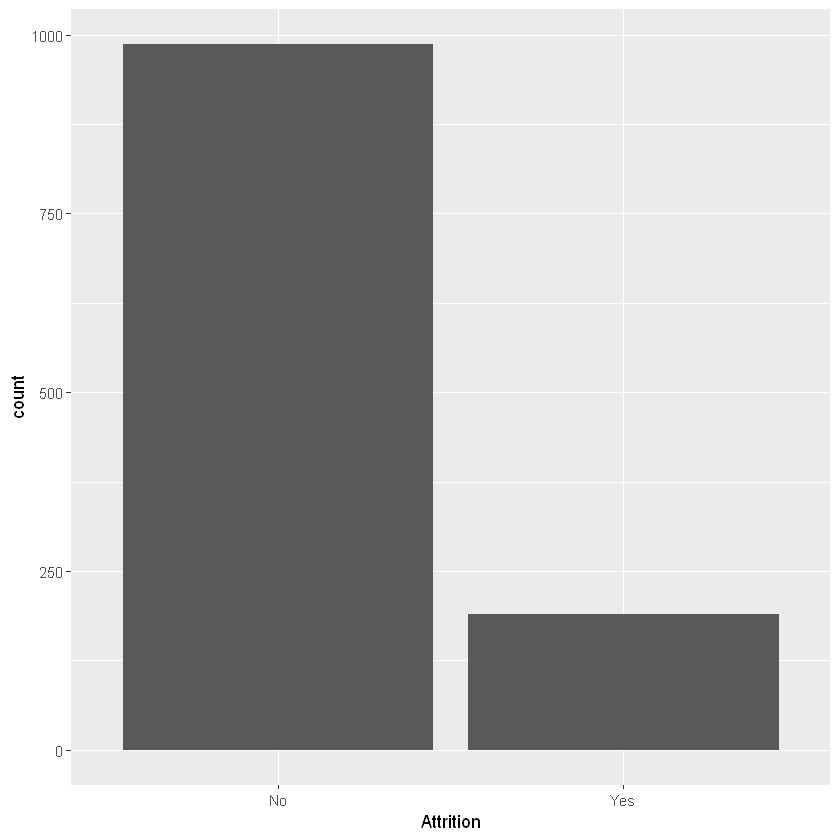

In [4]:
ggplot(orig, aes(x = Attrition)) + geom_bar()

In [42]:
set_col_to_factor <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols){
    df[, col] <- as.factor(df[, col])
  }
  return(df)
}
set_col_to_integer <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols) {
    df[, col] <- as.integer(df[, col])
  }
  return(df)
}
set_col_to_numeric <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols){
    if(is.factor(df[, col])){
      df[, col] <- as.numeric(as.character(df[, col]))
    }else{
      df[, col] <- as.numeric(df[, col])      
    }
  } 
  return (df)
}
set_col_to_category <- function(df, old_col, new_col, mapper){
  df[new_col] <- as.factor(mapper(df[old_col]))
  return(df)
}
set_col_to_numerical_factor <- function(df, old_col, new_col) {
  df[, new_col] <- as.factor(as.numeric(as.factor(df[, old_col])))
  return(df)
}

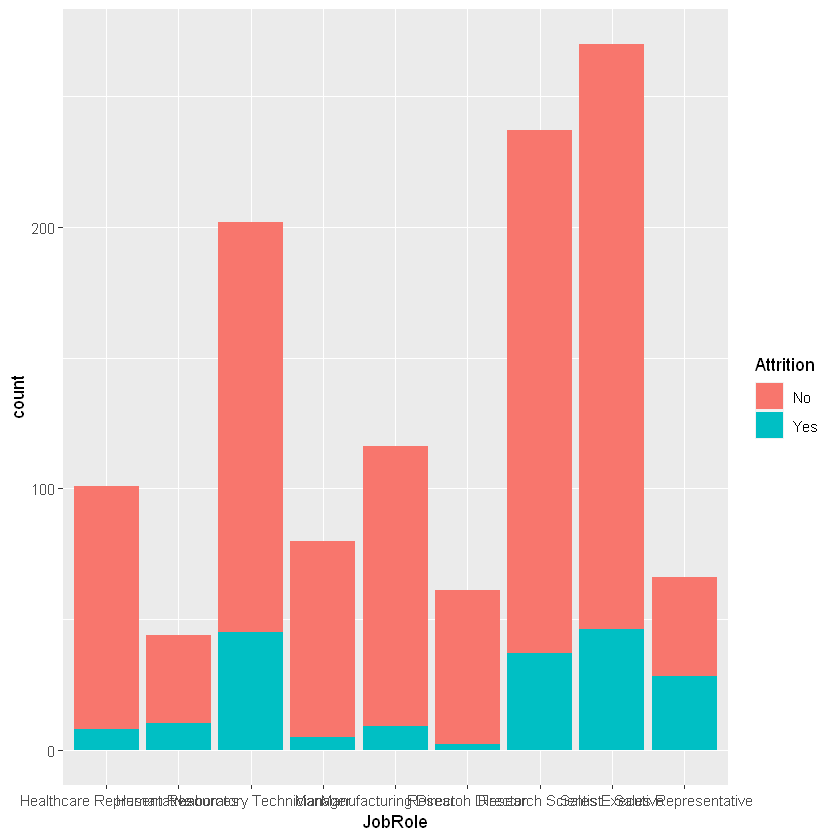

In [43]:
ggplot(orig, aes(x = JobRole, fill = Attrition)) + geom_bar()

In [13]:
build_fold_indices <- function(fold) {
  test_fold <- 1:fold
  shifted <- (test_fold + 1)
  valid_fold <- ifelse((shifted > fold), shifted %% fold, shifted)
  fold_indices <- data.frame(test = test_fold, valid = valid_fold)
  
  return(fold_indices)
}
pick_out_indices <- function(total_rows, fold, ...) {
  indices <- c()
  for (i in list(...)) {
    indices <- append(indices, seq(i, total_rows, fold))
  }
  indices <- unique(indices)
  return(indices)
}
get_by_exclude <- function(df, fold, ...) {
  total_rows <- nrow(df)
  exclude <- pick_out_indices(total_rows, fold, ...)
  excluded <- df[-exclude,]
  return(excluded)
}
get_by_index <- function(df, fold, ...) {
  total_rows <- nrow(df)
  include <- pick_out_indices(total_rows, fold, ...)
  included <- df[include,]
  return(included)
}
subset_by_fold <- function(df, fold, index, indices){
  training_frame <- get_by_exclude(df,
                                   fold,
                                   indices[index, ]$test,
                                   indices[index, ]$valid)
  validation_frame <- get_by_index(df, fold, indices[index, ]$valid)
  testing_frame <- get_by_index(df, fold, indices[index, ]$test)
  return(list(training=training_frame,
              validation=validation_frame,
              testing=testing_frame))
}
shuffle_frame <- function(df){
   set.seed(28657)
   shf_rows <- sample(nrow(df))
   shf_train <- df[shf_rows, ]
   return(shf_train)
}
remove_cols <- function(df, ...){
  cols <- unlist(list(...))
  new_df <- df[, !(names(df) %in% cols)]
  return(new_df)
}

In [14]:
as.factor(as.numeric(orig[, 'JobRole']))

[1] 8 7 3 7 3 3 3 3 1 3 7 3 3 7 3 4 7 5 9 6 4 7 8 1 4 3 1 3 9 7 9 9 7 8 3 3 3
  [38] 8 3 6 7 8 3 3 8 1 6 8 3 3 5 3 8 4 5 7 7 7 8 7 7 5 8 6 6 3 7 8 7 5 5 9 3 1
  [75] 8 8 8 8 8 3 2 7 3 7 6 8 3 1 4 7 8 4 8 4 8 6 8 7 1 9 3 5 8 8 2 5 8 8 2 3 7
 [112] 7 7 8 4 3 3 7 8 3 8 5 5 8 7 7 1 7 4 7 8 7 7 9 3 3 8 7 8 3 7 7 9 5 7 4 6 1
 [149] 4 7 5 4 7 3 5 5 5 7 3 1 7 3 1 1 8 5 8 6 8 8 3 7 8 5 8 8 7 3 4 3 4 9 3 7 6
 [186] 7 5 5 5 1 7 7 8 5 3 7 3 3 8 3 4 3 8 1 1 1 3 4 4 8 7 4 8 5 6 8 8 1 7 1 3 7
 [223] 6 7 9 8 7 3 8 3 5 4 9 1 1 3 1 7 3 7 4 4 7 7 8 8 7 7 5 4 8 8 6 3 7 1 8 3 8
 [260] 6 5 8 5 7 5 9 6 8 3 4 8 8 9 8 8 1 3 9 9 8 1 8 7 9 1 3 8 1 8 7 8 8 7 7 7 3
 [297] 8 3 5 6 3 6 8 5 1 8 7 3 4 8 8 3 3 5 7 5 1 9 3 4 3 6 7 2 8 4 4 3 8 5 6 3 3
 [334] 7 8 5 4 3 1 2 8 8 8 8 5 3 8 5 2 5 6 4 9 8 1 8 8 8 3 5 1 4 8 8 9 1 5 6 7 3
 [371] 4 3 9 7 8 3 8 8 7 1 6 7 4 2 9 9 7 8 7 7 8 7 8 5 8 7 1 2 7 7 7 3 7 8 8 7 8
 [408] 8 7 3 8 1 8 8 5 6 8 8 6 4 8 5 4 9 7 5 8 8 9 7 1 3 2 1 7 1 9 3 1 7 5 4 8 9
 [445] 7 8 8 4 7 3 1 7 5 8 7 5 7 3 1 8 4 3 3 6 6 8 4 5 7 6 7 5 2 5 3 5 7 5 1 7 8
 [482] 6 6 5 8 2 7 7 4 7 8 7 8 8 7 8 8 8 2 5 2 5 7 3 8 7 3 8 9 3 9 8 9 1 8 8 4 2
 [519] 2 3 7 3 5 9 7 1 9 5 3 7 3 7 3 8 1 9 1 3 8 7 3 9 8 3 3 3 1 7 5 8 1 8 3 9 4
 [556] 7 8 8 8 8 8 8 7 7 3 6 1 6 3 3 8 7 5 7 5 5 5 7 5 6 3 5 3 1 5 5 5 3 4 5 1 6
 [593] 8 4 8 3 5 9 3 8 4 2 8 7 9 7 1 8 7 6 5 8 9 3 7 7 1 3 7 1 3 5 7 2 1 7 3 1 3
 [630] 3 7 4 3 8 7 4 8 1 8 7 5 5 1 6 7 3 7 8 8 5 7 5 2 7 8 3 3 1 7 2 8 6 8 8 3 3
 [667] 3 8 7 5 1 3 8 9 4 7 5 3 7 4 7 4 7 2 7 8 8 3 6 8 3 8 3 3 7 9 5 2 8 3 7 5 7
 [704] 8 8 7 6 8 7 7 7 7 1 1 8 6 4 7 3 7 1 7 4 8 7 7 9 7 4 1 3 4 8 5 3 4 2 7 7 8
 [741] 5 1 3 3 3 7 7 4 4 7 3 7 3 1 2 3 6 8 8 5 8 8 9 3 4 4 4 7 1 7 8 7 4 8 8 3 8
 [778] 9 5 3 8 8 5 7 3 9 8 7 1 8 5 8 8 7 7 8 8 5 7 8 7 7 4 3 3 3 2 3 1 6 6 8 9 8
 [815] 6 7 7 3 3 8 7 9 3 7 6 8 8 3 7 8 5 1 2 3 8 2 6 8 3 1 7 7 8 8 8 1 6 9 8 8 9
 [852] 9 5 8 2 1 3 8 3 7 8 3 3 7 6 5 4 1 3 3 7 6 9 7 1 5 7 8 3 4 3 1 9 7 9 7 8 8
 [889] 2 3 8 3 5 5 7 7 4 7 7 8 8 3 4 7 3 4 3 3 3 3 7 6 3 8 8 5 5 3 5 7 7 4 3 5 1
 [926] 5 5 5 8 7 5 2 4 8 7 7 7 3 8 1 5 5 6 7 3 5 1 4 6 8 7 8 8 7 8 3 3 4 8 9 1 3
 [963] 3 1 9 3 7 3 1 3 1 7 8 3 2 8 2 5 3 1 5 8 8 8 3 5 3 8 4 2 7 2 2 7 9 8 7 8 8
[1000] 3 8 7 1 1 7 3 6 7 8 5 2 8 9 3 3 8 4 8 6 1 7 2 7 6 8 1 5 2 3 5 7 1 2 1 1 8
[1037] 4 3 5 1 7 8 7 9 8 6 7 8 8 3 8 7 3 5 2 3 8 8 9 2 4 6 8 7 7 7 9 7 8 3 8 3 7
[1074] 5 2 4 7 4 1 7 3 8 8 6 8 8 3 8 8 9 8 7 7 8 7 8 5 7 4 7 6 8 2 8 7 7 3 8 8 1
[1111] 7 9 8 8 5 8 8 7 1 1 4 8 7 5 1 3 8 2 3 3 3 8 9 7 7 6 3 7 1 3 9 7 6 8 6 8 9
[1148] 7 9 4 9 8 5 1 4 3 5 8 8 8 7 2 8 8 8 7 1 7 7 3 7 8 5 9 3 1 8
Levels: 1 2 3 4 5 6 7 8 9

In [17]:
gender_mapper <- function(gender){
  return(ifelse(gender == 'Male', 1, 0))
}
age_mapper <- function(age) {
  return(ifelse(age <= 30, 2,
         ifelse((31<= age && age <= 45), 3,
         ifelse(age <= 45, 1, 0))))
}
travel_mapper <- function(travel) {
  return(ifelse(travel=='Travel_Rarely', 3,
         ifelse(travel=='Travel_Frequently', 2,
         ifelse(travel=='Non-Travel', 1, 0))))
}
department_mapper <- function(department){
  return(ifelse(department=='Human Resources', 1,
         ifelse(department=='Sales', 2,
         ifelse(department=='Research & Development', 3, 0))))
}
field_mapper <- function(field) {
  # 'Medical''Other''Marketing''Human Resources''Technical Degree'
  return(ifelse(field=='Medical', 1, 
         ifelse(field=='Other', 2,
         ifelse(field=='Marketing', 3,
         ifelse(field=='Human Resources', 4,
         ifelse(field=='Technical Degree', 5, 0))))))
}
marital_mapper <- function(marital){
  return(ifelse(marital=='Single', 1,
         ifelse(marital=='Married', 2,
         ifelse(marital=='Divorced', 3, 0))))
}

wrangling_process <- function(df){
  df <- set_col_to_category(df, 'Gender', 'Gender_1', gender_mapper)
  df <- set_col_to_category(df, 'Age', 'Age_1', age_mapper)
  df <- set_col_to_category(df, 'BusinessTravel', 'BusinessTravel_1', travel_mapper)
  df <- set_col_to_category(df, 'Department', 'Department_1', department_mapper)
  df <- set_col_to_category(df, 'EducationField', 'EducationField_1', field_mapper)
  # df <- set_col_to_category(df, 'JobRole', 'JobRole_1', job_mapper)
  df <- set_col_to_numerical_factor(df, 'JobRole', 'JobRole_1')
  df <- set_col_to_category(df, 'MaritalStatus', 'MaritalStatus_1', marital_mapper)
  
  df <- remove_cols(df, 'Gender', 'Age', 'BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus')
  
  return(df)
}

In [19]:
fold <- 3
index <- 1
df <- shuffle_frame(wrangling_process(orig))
fold_indices <- build_fold_indices(fold)
splitted_frames <- subset_by_fold(df, fold, index, fold_indices)
head(splitted_frames$training)

,Attrition,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Gender_1,Age_1,BusinessTravel_1,Department_1,EducationField_1,JobRole_1,MaritalStatus_1
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
526,No,14,1,924,3,3,2,4,6586,0,3,1,1,17,2,2,16,8,4,11,1,3,3,3,0,1,2
406,No,1,4,710,2,1,1,4,2720,1,3,4,1,10,5,3,10,7,2,8,1,2,2,3,0,7,3
182,No,4,2,330,3,3,1,2,3931,2,3,1,1,6,5,3,4,3,1,2,0,3,3,2,0,9,2
1176,No,6,1,2062,4,2,3,1,9991,4,3,1,1,9,5,3,7,7,1,7,1,3,3,3,1,1,2
463,No,11,4,813,4,3,2,3,3149,8,4,2,1,9,3,3,5,2,1,4,0,3,3,3,0,3,2
297,No,2,2,516,4,3,2,2,5715,7,3,3,2,8,5,3,5,4,1,3,0,3,3,2,3,8,3


In [20]:
library(rpart)

train_dt <- function(df, depth=5) {
  model <- rpart(
    Attrition ~ .,
    data = df,
    control = rpart.control(maxdepth = depth),
    method = "class"
  )
  return (model)
}

predict_dt <- function(model, df) {
  pred_frame <- predict(model, df, type = "class")
  return (pred_frame)
}

In [21]:
library(randomForest)

train_rf <- function(df) {
   model <- randomForest(
     Attrition ~ .,
     data = df,
     mtry = 9,
     importance=TRUE,
     proximity=TRUE,
     ntree=500)

   return (model)
 }

 predict_rf <- function(model, df) {
   pred_frame <- predict(model, df)

   return (pred_frame)
 }

In [22]:
build_cm <- function(df, pred) {
  result_frame <- data.frame(truth = df$Attrition,
                             pred = pred)
  result_table <- table(result_frame)
  return(result_table)
}

cal_pred_result <- function(cM) {
  true_col <- 2
  false_col <- 1
  positive_row <- 2
  negative_row <- 1
  
  TP <- cM[positive_row, ][true_col]
  FN <- cM[positive_row, ][false_col]
  TN <- cM[negative_row, ][false_col]
  FP <- cM[negative_row, ][true_col]
  
  result <- c(TP, FP, TN, FN)
  names(result) = c("TP", "FP", "TN", "FN")
  return(result)
}

get_rounded <- function(value, round_digits = 2) {
  return(round(value, digits = round_digits))
}

cal_accu <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FN <- unname(pred_result["FN"])
  TN <- unname(pred_result["TN"])
  FP <- unname(pred_result["FP"])
  total_rows = TP + FN + TN + FP
  accuracy <- (TP + TN) / total_rows
  return(get_rounded(accuracy))
}

cal_sensitivity <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FN <- unname(pred_result["FN"])
  sensitivity <- TP / (TP + FN)
  return(get_rounded(sensitivity))
}

cal_specificity <- function(pred_result) {
  TN <- unname(pred_result["TN"])
  FP <- unname(pred_result["FP"])
  specificity <- TN / (TN + FP)
  return(get_rounded(specificity))
}

cal_F1 <- function(pred_result) {
  precision <- cal_precision(pred_result)
  recall <- cal_sensitivity(pred_result)
  F1 <- (2 * precision * recall) / (precision + recall)
  return(get_rounded(F1))
}

cal_precision <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FP <- unname(pred_result["FP"])
  precision <- TP / (TP + FP)
  return(get_rounded(precision))
}

evaluate_model <- function(df, pred){
  predict_cm <- build_cm(df, pred)
  predict_result <- cal_pred_result(predict_cm)
  accu <- cal_accu(predict_result)
  preci <- cal_precision(predict_result)
  sens <- cal_sensitivity(predict_result)
  recl <- sens
  spec <- cal_specificity(predict_result)
  f1 <- cal_F1(predict_result)
  
  return(list(cm=predict_cm,
              result=predict_result,
              accuracy=accu,
              recall=recl,
              precision=preci,
              sensitivity=sens,
              specificity=spec,
              F1=f1))
}

In [23]:
trainer <- (function(df) train_rf(df))
predictor <- (function(model, df) predict_rf(model, df))

model <- trainer(splitted_frames$training)

pred_train <- predictor(model, splitted_frames$training)
result_train <- evaluate_model(splitted_frames$training, pred_train)
pred_valid <- predictor(model, splitted_frames$validation)
result_valid <- evaluate_model(splitted_frames$validation, pred_valid)
pred_test <- predictor(model, splitted_frames$testing)
result_test <- evaluate_model(splitted_frames$testing, pred_test)

In [24]:
print('train result:')
print(result_train)

[1] "train result:"
$cm
     pred
truth  No Yes
  No  331   0
  Yes   0  61

$result
 TP  FP  TN  FN 
 61   0 331   0 

$accuracy
[1] 1

$recall
[1] 1

$precision
[1] 1

$sensitivity
[1] 1

$specificity
[1] 1

$F1
[1] 1



In [25]:
print('validation:')
print(result_valid)

[1] "validation:"
$cm
     pred
truth  No Yes
  No  319   8
  Yes  55  10

$result
 TP  FP  TN  FN 
 10   8 319  55 

$accuracy
[1] 0.84

$recall
[1] 0.15

$precision
[1] 0.56

$sensitivity
[1] 0.15

$specificity
[1] 0.98

$F1
[1] 0.24



In [26]:
print('testing')
print(result_test)

[1] "testing"
$cm
     pred
truth  No Yes
  No  317  12
  Yes  59   5

$result
 TP  FP  TN  FN 
  5  12 317  59 

$accuracy
[1] 0.82

$recall
[1] 0.08

$precision
[1] 0.29

$sensitivity
[1] 0.08

$specificity
[1] 0.96

$F1
[1] 0.13



In [30]:
library(ggbiplot)
draw_pca <- function(df, x, y){
  ggbiplot(df.pca, choices=c(x, y),
          obs.scale=1, var.scale=1,
          ellipse=TRUE, ellipse.prob=0.68,
          circle=TRUE, circle.prob=0.68,
          groups=df.cate)
}

In [31]:
colnames(df)

[1] "Attrition"                "DistanceFromHome"        
 [3] "Education"                "EmployeeNumber"          
 [5] "EnvironmentSatisfaction"  "JobInvolvement"          
 [7] "JobLevel"                 "JobSatisfaction"         
 [9] "MonthlyIncome"            "NumCompaniesWorked"      
[11] "PerformanceRating"        "RelationshipSatisfaction"
[13] "StockOptionLevel"         "TotalWorkingYears"       
[15] "TrainingTimesLastYear"    "WorkLifeBalance"         
[17] "YearsAtCompany"           "YearsInCurrentRole"      
[19] "YearsSinceLastPromotion"  "YearsWithCurrManager"    
[21] "Gender_1"                 "Age_1"                   
[23] "BusinessTravel_1"         "Department_1"            
[25] "EducationField_1"         "JobRole_1"               
[27] "MaritalStatus_1"

In [32]:
head(df, n=3)

,Attrition,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Gender_1,Age_1,BusinessTravel_1,Department_1,EducationField_1,JobRole_1,MaritalStatus_1
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
631,Yes,25,3,1108,1,2,1,2,2313,4,4,2,0,5,0,3,2,2,2,2,1,3,3,3,1,7,1
408,No,3,1,714,4,4,2,4,4647,1,4,2,2,6,3,3,6,5,0,4,0,2,2,2,1,8,3
526,No,14,1,924,3,3,2,4,6586,0,3,1,1,17,2,2,16,8,4,11,1,3,3,3,0,1,2


In [46]:
# Gender_1, Age_1, BusinessTravel_1, Department_1, EducationField_1, JobRole_1, MaritalStatus_1
df <- set_col_to_numeric(df, 'Gender_1', 'Age_1', 'BusinessTravel_1', 'Department_1', 'EducationField_1', 'JobRole_1', 'MaritalStatus_1')

df.log <- log(df[, 2:27])
df.log

,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Gender_1,Age_1,BusinessTravel_1,Department_1,EducationField_1,JobRole_1,MaritalStatus_1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
631,3.2188758,1.0986123,7.010312,0.0000000,0.6931472,0.0000000,0.6931472,7.746301,1.3862944,1.386294,0.6931472,-Inf,1.6094379,-Inf,1.0986123,0.6931472,0.6931472,0.6931472,0.6931472,0,1.0986123,1.0986123,1.0986123,0.0000000,1.9459101,0.0000000
408,1.0986123,0.0000000,6.570883,1.3862944,1.3862944,0.6931472,1.3862944,8.443977,0.0000000,1.386294,0.6931472,0.6931472,1.7917595,1.0986123,1.0986123,1.7917595,1.6094379,-Inf,1.3862944,-Inf,0.6931472,0.6931472,0.6931472,0.0000000,2.0794415,1.0986123
526,2.6390573,0.0000000,6.828712,1.0986123,1.0986123,0.6931472,1.3862944,8.792701,-Inf,1.098612,0.0000000,0.0000000,2.8332133,0.6931472,0.6931472,2.7725887,2.0794415,1.3862944,2.3978953,0,1.0986123,1.0986123,1.0986123,-Inf,0.0000000,0.6931472
587,0.6931472,1.3862944,6.934397,0.0000000,1.0986123,0.6931472,1.3862944,8.349248,-Inf,1.098612,0.6931472,0.0000000,1.3862944,0.6931472,1.0986123,1.0986123,0.6931472,0.6931472,0.6931472,-Inf,0.6931472,1.0986123,1.0986123,-Inf,1.6094379,0.6931472
103,2.9957323,1.0986123,5.164786,0.6931472,0.0000000,0.6931472,1.0986123,8.424859,1.0986123,1.098612,1.0986123,0.0000000,1.3862944,0.6931472,1.0986123,0.6931472,0.6931472,0.6931472,0.6931472,-Inf,1.0986123,1.0986123,0.6931472,-Inf,2.0794415,0.6931472
406,0.0000000,1.3862944,6.565265,0.6931472,0.0000000,0.0000000,1.3862944,7.908387,0.0000000,1.098612,1.3862944,0.0000000,2.3025851,1.6094379,1.0986123,2.3025851,1.9459101,0.6931472,2.0794415,0,0.6931472,0.6931472,1.0986123,-Inf,1.9459101,1.0986123
449,2.9444390,1.3862944,6.673298,1.3862944,1.0986123,0.0000000,1.3862944,8.356555,-Inf,1.098612,0.0000000,0.0000000,1.6094379,1.0986123,1.0986123,1.3862944,1.0986123,0.0000000,0.6931472,0,1.0986123,0.0000000,1.0986123,0.0000000,1.9459101,0.6931472
65,1.9459101,1.3862944,4.624973,0.0000000,1.0986123,1.0986123,1.0986123,9.522520,1.3862944,1.098612,0.0000000,-Inf,2.7725887,1.0986123,1.3862944,1.6094379,0.6931472,-Inf,0.6931472,0,1.0986123,1.0986123,1.0986123,0.0000000,1.7917595,0.0000000
182,1.3862944,0.6931472,5.799093,1.0986123,1.0986123,0.0000000,0.6931472,8.276649,0.6931472,1.098612,0.0000000,0.0000000,1.7917595,1.6094379,1.0986123,1.3862944,1.0986123,0.0000000,0.6931472,-Inf,1.0986123,1.0986123,0.6931472,-Inf,2.1972246,0.6931472


In [ ]:
df.cate <- df[, 1]
df.pca <- prcomp(df.log, center = TRUE, scale. = TRUE)
draw_pca(df)